In [76]:
import os
import numpy as np

class OceanHelper:
    def __init__(self, ocean_dir, x_template):
        self.ocean_dir = ocean_dir
        self.x_template = ocean_dir + x_template
        self.var_start = 29
        self.output_start = 46
        self.param_names = ["Ln", "Lp", "Wn", "Wp", "Vbias"]
        self.param_sufixes = ["n", "n", "n", "n", ""]
        
    def compute_fitness(self):
        os.system("ocean -restore " + self.ocean_dir + "population.ocn")
        
    def create_population(self, n):
        f = open(self.ocean_dir + "population.ocn", "w")
        
        with open(self.x_template, 'r') as file:
            data = file.readlines()
        
        for i in range(0, n):
            f.write("load(\"" + self.ocean_dir + "x_" + str(i) + ".ocn\")\n")
            
            filename = self.ocean_dir + "x_" + str(i) + ".ocn"
            
            new_data = data.copy()
            
            for j in range(0, len(data)):
                new_data[j] = new_data[j].replace("_n.txt", "_" + str(i) + ".txt")

            with open(filename, 'w') as file:
                file.writelines( new_data )
        
        f.write("exit()")
        f.close()
    
    # Ordem dos parametros:
    # params = [Ln, Lp, Wn, Wp, Vbias]
    def update_x(self, params, n):
        filename = self.ocean_dir + "x_" + str(n) + ".ocn"
        with open(filename, 'r') as file:
            data = file.readlines()
        
        for i in range(0, len(self.param_names)):
            data[i+self.var_start] = "desVar( \"" + self.param_names[i]  + "\" " + str(params[i]) + self.param_sufixes[i] + " )\n"
        
        with open(filename, 'w') as file:
            file.writelines( data )
    
    def eng2num(self, eng):
        symbol_table = ['a', 'p', 'n', 'u', 'm', '','k']
        last_char = eng[-1]
        eng_len = len(eng)
        
        if last_char.isnumeric():
            last_char = ''
            eng_len += 1
            
        power = -15 + 3*symbol_table.index(last_char)
        
        return float(eng[0:eng_len-1])*10**power
        
        
    def read_response(self, waveform, n):
        wave_data_str = np.loadtxt("./SimulationOutputs/" + waveform + "_" + str(n) + ".txt", skiprows=3, dtype=str)
#         print(wave_data_str)
        wave_data_float = np.zeros(wave_data_str.size)
        vec_eng2num = np.vectorize(self.eng2num)
        wave_data_float = vec_eng2num(wave_data_str)
        
        return wave_data_float
    
    def compute_fitness(self, n, target):
        vout = OH.read_response("vout", 1)
        vin = OH.read_response("vin", 1)
        target_wave = (vin[:, 1] > target)*1.8
        rmse = np.sqrt(np.mean((vout[:,0] - target_wave)**2))
        return 1/rmse
        
        

In [77]:
OH = OceanHelper('./OceanScripts/', 'x_template.ocn')
OH.create_population(3)
params = [180, 180, 240, 720, 1]
params = [320, 180, 240, 720, 1]
OH.update_x(params, 0)

In [84]:
OH.compute_fitness(1, 0.7)

0.8769360807439381

In [80]:
vout = OH.read_response("vout", 1)
vin = OH.read_response("vin", 1)
vcomp = OH.read_response("vcomp", 1)

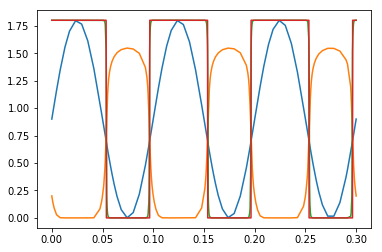

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
target = 0.7
plt.plot(vin[:, 0], vin[:, 1])
plt.plot(vcomp[:, 0], vcomp[:, 1])
target_wave = (vin[:, 1] > target)*1.8
plt.plot(vout[:, 0], vout[:, 1])
plt.plot(vout[:, 0], target_wave)
plt.show();

In [70]:
OH.compute_fitness()